# Linear Regression Models



# PART 1: Linear regression for red light violations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('all_hours',)]
cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe

## Query our data
We will start by making a model to measure changing outside effects on our crashes.  These are weather, traffic, and temporal.  I will do d separate and simpler study of intersection characteristics and how they affect crashes.


I would like to get daily red light camera intersection data with the following columns:
- violations
- weekday
- month
- year
- region   (can add this post query with lambda function from intersection_cams and region_data tables, ugh!)
- congestion (try peak, rush hour, average, etc)
- precipitation
- max_temp

Each intersection should have one entry per day.  Weather will use aggregate daily values.
Congestion will use aggragate also, although I am look for congestion at rush hour as a factor.


In [5]:
# get a df with all relevant data.

int_df = pd.read_sql_query('''
WITH 
    ah AS(
        SELECT *
        FROM all_hours
        ),

    v as
    (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

ic as
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c as
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT allcg.speed,
           allcg.min_speed,
           allcg.region_id,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            allcg.quantile_speed,
            allcg.avg_congestion,

            rh1.morning_rush_speed,
            rh1.morning_rush_quant,
            rh1.morning_rush_congestion,

            rh2.afternoon_rush_speed,
            rh2.afternoon_rush_quant,
            rh2.afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id

     ORDER BY allcg.year, allcg.month, allcg.day, allcg.region_id
),


 wx as
    (SELECT temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year    
     FROM hourly_weather
     GROUP BY year, month, day
    )

SELECT  SUM(v.violations) as violations,
        v.year,
        CAST(v.month as INT) as month,
        v.day,

        AVG(c.speed) as speed, 
        CAST(c.quantile_speed as REAL) as quantile_speed,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.avg_congestion) as avg_congestion,
        AVG(c.morning_rush_speed) as morning_rush_speed,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp

FROM v
LEFT JOIN ic
  ON v.intersection = ic.intersection
LEFT JOIN c
  ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
      AND c.region_id = ic.region_id
LEFT JOIN wx
  ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

                                    ''', conn)

# LOOKS GOOD!!
print(int_df.info())
int_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 17 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_speed           1187 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-null int64
precip                       1217 non-null float64
temp                         1217 non-null float64
dtypes: float64(12), int64(5)
memory

,violations,year,month,day,speed,quantile_speed,min_speed,avg_congestion,morning_rush_speed,morning_rush_quant,morning_rush_congestion,afternoon_rush_speed,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp
0,1704,2017,9,1,22.693942,37.936256,23.748333,62.690059,21.440603,12.106900,0.878931,18.826903,5.208570,0.947914,4,0.00,294.15
1,1623,2017,9,2,23.965360,56.462902,26.930000,50.357674,25.253151,49.488127,0.505119,21.525069,22.243180,0.777568,5,0.00,292.15
2,1494,2017,9,3,24.892638,69.651336,27.898333,38.921189,26.114819,62.351127,0.376489,23.260429,42.655756,0.573442,6,6.60,295.15
3,1258,2017,9,4,24.509224,64.672707,28.285000,44.127042,25.901678,64.182735,0.358173,23.335408,42.007748,0.579923,0,1.12,300.15
4,1366,2017,9,5,22.674090,39.022544,22.885000,62.243650,20.890598,6.379359,0.936206,18.663253,3.675793,0.963242,1,0.00,297.15


Now we have a pretty solid dataframe to do analysis on the red light intersections.

We would like to know what factors affect the target (violations)

In [6]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [7]:
int_df.dropna(inplace=True)

In [8]:
# Change weekday to string
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
int_df['weekday'] = int_df['weekday'].apply(lambda x: days_of_week[x])

months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']

int_df['month'] = int_df['month'].apply(lambda x: months[x-1])


In [9]:
# Lets look at some regressions for all of my chosen columns



# Eliminated and useful features
target = 'violations'
drop_me = ['day', 'min_speed', 'speed', 'quantile_speed', 'avg_congestion', 'month',
          'afternoon_rush_speed', 'morning_rush_speed', 'afternoon_rush_quant', 'morning_rush_quant', 'year']
categoricals = ['weekday', 'month']

df_cont = int_df.copy()
df_cont.drop(columns=drop_me+categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    #fig, axes = plt.subplots(figsize=(15,12))
    #fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    #fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    #fig.tight_layout()
    #plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:             violations   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.014e+32
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:31:12   Log-Likelihood:                 30846.
No. Observations:                1182   AIC:                        -6.169e+04
Df Residuals:                    1180   BIC:                        -6.168e

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
3,precip,0.016391,1.507725e+03,-3.315640,1.009767e-05,17.878072
1,morning_rush_congestion,0.077529,1.741087e+03,-389.788773,1.733401e-22,12.276124
2,afternoon_rush_congestion,0.100980,1.927046e+03,-571.286945,3.841101e-29,8.863278
4,temp,0.440710,-3.974151e+03,19.075055,4.459325e-151,86.978550
0,violations,1.000000,1.136868e-13,1.000000,0.000000e+00,83.449980


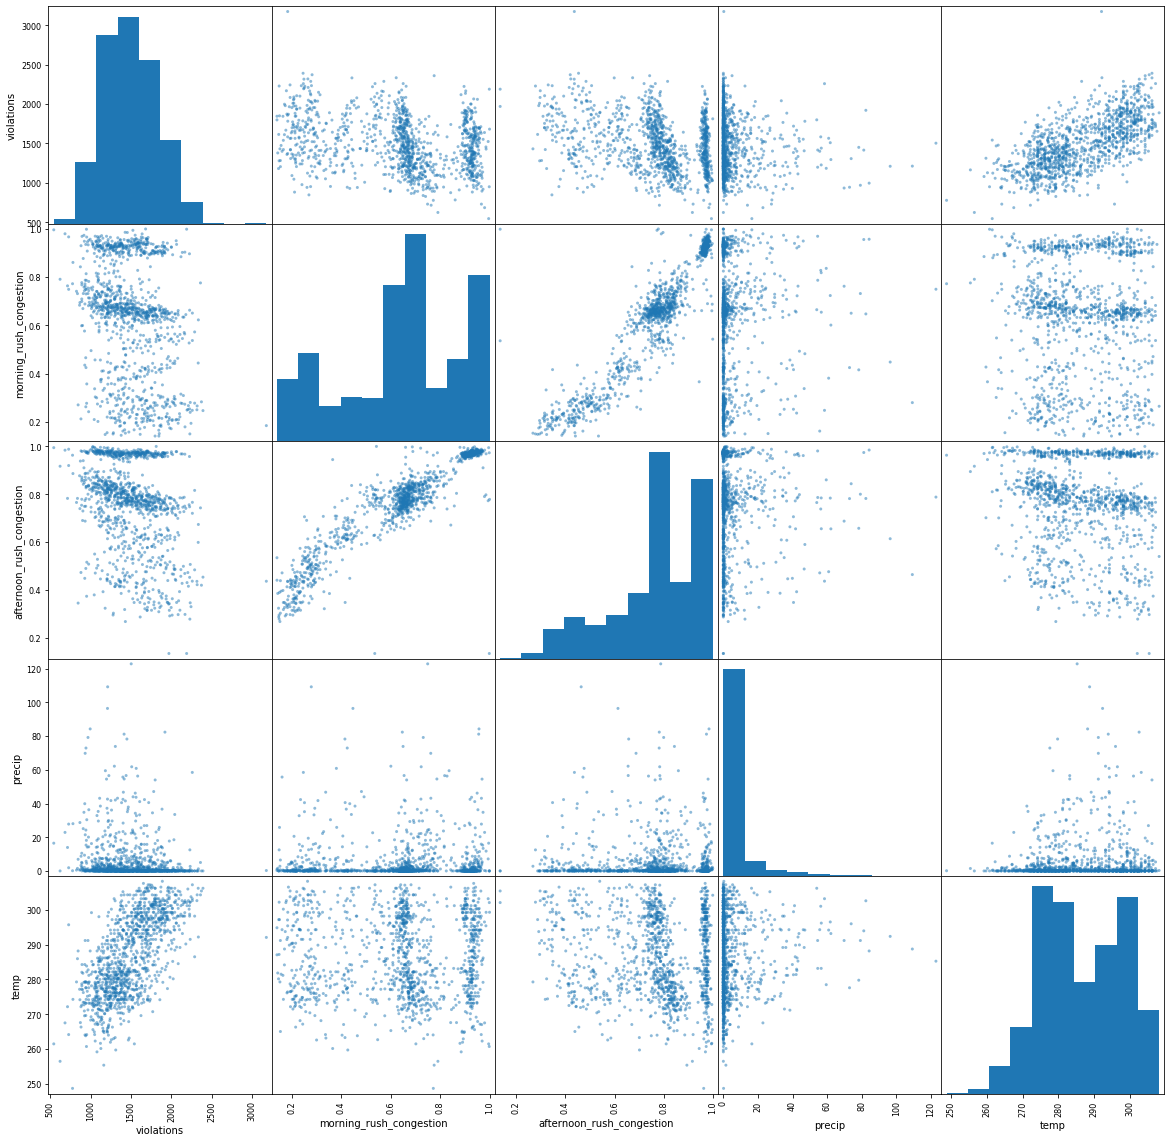

In [10]:
# scatter plot takes a few min

pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
plt.show()

In [11]:
df_cont.corr()  # create a correlation matrix

,violations,morning_rush_congestion,afternoon_rush_congestion,precip,temp
violations,1.000000,-0.278441,-0.317774,-0.128026,0.663860
morning_rush_congestion,-0.278441,1.000000,0.931563,0.002293,-0.012702
afternoon_rush_congestion,-0.317774,0.931563,1.000000,-0.035445,-0.123987
precip,-0.128026,0.002293,-0.035445,1.000000,0.063800
temp,0.663860,-0.012702,-0.123987,0.063800,1.000000


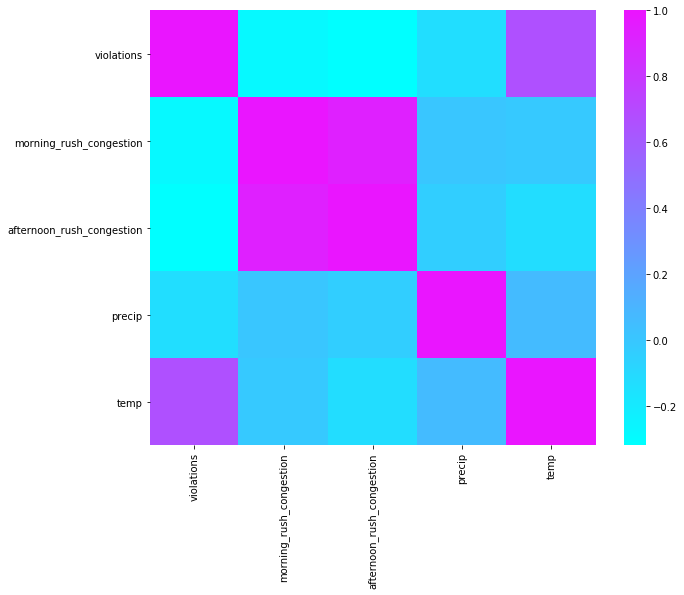

In [12]:
import seaborn as sns

plt.figure(figsize = (10,8))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [13]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = int_df.drop(columns=list(df_continuous.columns) + drop_me +[target])


# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [14]:
pd.options.display.max_columns = 100
df_final.head()

,violations,morning_rush_congestion,afternoon_rush_congestion,precip,temp,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1704,0.878931,0.947914,0.00,294.15,0,0,0,0,0,0
1,1623,0.505119,0.777568,0.00,292.15,0,1,0,0,0,0
2,1494,0.376489,0.573442,6.60,295.15,0,0,1,0,0,0
3,1258,0.358173,0.579923,1.12,300.15,1,0,0,0,0,0
4,1366,0.936206,0.963242,0.00,297.15,0,0,0,0,1,0


In [15]:
df_final.dropna(inplace=True)

### Test train split

In [16]:
X = df_final.drop(['violations'], axis=1)
y = df_final['violations']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
def cross_val(model, X, y):
    # return a cross val score for my models
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()

def print_evaluate(true, predicted):  
    # print out all of my stats for the model
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    # get multiple stats on my model predictions
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [18]:
# pipeline = Pipeline([
#     ('std_scalar', StandardScaler())
# ])

# X_train = pipeline.fit_transform(X_train)
# X_test = pipeline.transform(X_test)

In [19]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

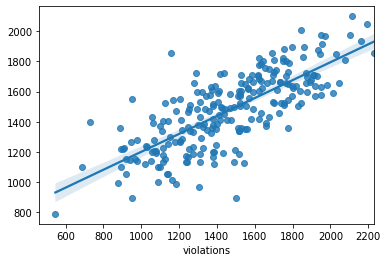

In [20]:
sns.regplot(y_test, pred)

### Plot residuals

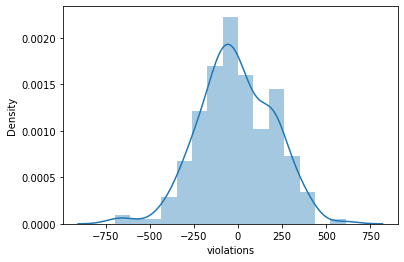

In [21]:
sns.distplot((y_test - pred), bins=15);

In [22]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 165.67621671776695
MSE: 43291.05536858231
RMSE: 208.06502677908728
R2 Square 0.5745572551084025

Train set:
MAE: 155.62126111118135
MSE: 40199.7100537348
RMSE: 200.49865349606415
R2 Square 0.6334613477708473


In [23]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,165.676217,43291.055369,208.065027,0.574557,0.621452


## Try Ridge Regression
Would like to try this since we likely have collinearity in our dataset.

In [24]:
from sklearn.linear_model import Ridge, RidgeCV

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print("Ridge Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Ridge Regression Results:
Test set:
MAE: 166.83844040095912
MSE: 44053.0601881722
RMSE: 209.8882087878502
R2 Square 0.5670686545347555

Train set:
MAE: 155.41474530844337
MSE: 40114.58113072209
RMSE: 200.28624798203717
R2 Square 0.6342375484117249


Ridge regression showed no improvement on original model.

In [25]:
ridge = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(RidgeCV(), X_train, y_train)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = results_df.append(ridge, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,165.676217,43291.055369,208.065027,0.574557,0.621452
1,Ridge Regression,166.838440,44053.060188,209.888209,0.567069,0.623029


In [26]:
#from sklearn.cross_validation import KFold



# Good time to do a baseline r_squared calculation
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(reg, X, y, scoring='r2', cv=crossvalidation))

# Do the actual regression
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:>12}: {}'.format(var, coefficients[var]))

print('Baseline r_squared val:', baseline)

morning_rush_congestion: -71.03775022135314
afternoon_rush_congestion: -100.87422546471397
      precip: -4.577182517371115
        temp: 19.274912759581316
weekday_Monday: -222.91743086652272
weekday_Saturday: 83.04279285723334
weekday_Sunday: -58.579122170303734
weekday_Thursday: -129.13113138930078
weekday_Tuesday: -223.92339187008622
weekday_Wednesday: -181.29655392317926
Baseline r_squared val: 0.6138339339830934


I need more information about the intersection other than just names.
I need descriptive info, but it isn't available in violations table.  Crash data does have some stuff though

# PART 2: Linear Regression for Crash Data
We will use the same approach as the violation data, looking only at outside influences and see if we can model the number of daily intersection crashes in Chicago

In [80]:
# Try to add in rlc_state to a very big already query
crash_df = pd.read_sql_query('''
WITH 
ah AS (SELECT MAX(rlc_state) as rlc_state,
            year,
            month,
            day,
            intersection
    FROM all_hours 
    GROUP BY year, month, day, intersection),

v AS (SELECT intersection,
            SUM(violations) AS violations,
            month,
            day,
            year,
            violation_date
    FROM daily_violations
    GROUP BY year, month, day, intersection
    ),

cr AS(SELECT year,
             month,
             day,
             COUNT(crash_record_id) AS n_crash,
             SUM(injuries_total) as injuries_total,
             SUM(injuries_fatal) as injuries_fatal

     FROM signal_crashes
     GROUP BY year, month, day
    ),

ic AS
    (SELECT region_id,
            intersection
     FROM intersection_cams
    ),



c AS
    (
        WITH allcg as 
             (SELECT AVG(speed) as speed,
                     AVG(quantile_speed) as quantile_speed,
                     100-AVG(quantile_speed) as avg_congestion,
                     MIN(speed) as min_speed,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             GROUP BY year, month, day, region_id
            ),

            rh1 as 
             (SELECT 
                    AVG(speed) as morning_rush_speed,
                    MIN(quantile_speed) as morning_rush_quant,
                    100 - MIN(quantile_speed) as morning_rush_congestion,
                    region_id,
                    month,
                    day,
                    weekday,
                    year
             FROM hourly_congestion
             WHERE hour > 5 AND hour < 10
             GROUP BY year, month, day, region_id
            ),

            rh2 as 
             (SELECT MIN(speed) as afternoon_rush_speed,
                    MIN(quantile_speed) as afternoon_rush_quant,
                    100 - MIN(quantile_speed) as afternoon_rush_congestion,
                    region_id,
                    month,
                    day,
                    year
             FROM hourly_congestion
             WHERE hour > 16 AND hour < 20
             GROUP BY year, month, day, region_id
            )

    SELECT allcg.speed,
           allcg.min_speed,
           allcg.region_id,
            allcg.month,
            allcg.day,
            allcg.weekday,
            allcg.year,
            allcg.quantile_speed,
            allcg.avg_congestion,

            rh1.morning_rush_speed,
            rh1.morning_rush_quant,
            rh1.morning_rush_congestion,

            rh2.afternoon_rush_speed,
            rh2.afternoon_rush_quant,
            rh2.afternoon_rush_congestion

     FROM allcg
     LEFT JOIN rh1
         ON rh1.year = allcg.year
         AND rh1.month = allcg.month
         AND rh1.day = allcg.day
         AND rh1.region_id = allcg.region_id
     LEFT JOIN rh2
         ON rh2.year = allcg.year
         AND rh2.month = allcg.month
         AND rh2.day = allcg.day
         AND rh2.region_id = allcg.region_id

     ORDER BY allcg.year, allcg.month, allcg.day, allcg.region_id
),


 wx as
    (SELECT MAX(temp) as temp,
            SUM(snow_1h)+SUM(rain_1h) as precip,
            month,
            day,
            weekday,
            year,
            SUM(snow_1h) as snow,
            SUM(rain_1h) as rain
     FROM hourly_weather
     GROUP BY year, month, day
    )

SELECT  SUM(v.violations) as violations,
        v.year,
        v.month,
        v.day,

        cr.injuries_total,
        cr.injuries_fatal,
        cr.n_crash,

        AVG(c.speed) as speed, 
        CAST(c.quantile_speed as REAL) as quantile_speed,
        CAST(c.min_speed as REAL) as min_speed,
        AVG(c.avg_congestion) as avg_congestion,
        AVG(c.morning_rush_speed) as morning_rush_speed,
        AVG(c.morning_rush_quant) as morning_rush_quant,
        (AVG(c.morning_rush_congestion))/100 as morning_rush_congestion,

        AVG(c.afternoon_rush_speed) as afternoon_rush_speed,
        AVG(c.afternoon_rush_quant) as afternoon_rush_quant,
        (AVG(c.afternoon_rush_congestion))/100 as afternoon_rush_congestion,

        wx.weekday,
        wx.precip,
        wx.temp,
        wx.snow,
        wx.rain,
        
        COUNT(ah.rlc_state) as n_cams,
        COUNT(ah.rlc_state==0) as cams_off

        

FROM v
LEFT JOIN ic
      ON v.intersection = ic.intersection
LEFT JOIN ah
    ON ah.year = v.year
    AND ah.month = v.month
    AND ah.day = v.day
    AND ah.intersection = v.intersection
LEFT JOIN c
      ON c.year = v.year
      AND c.month = v.month
      AND c.day = v.day
      AND c.region_id = ic.region_id
LEFT JOIN wx
      ON wx.year = v.year
      AND wx.month = v.month
      AND wx.day = v.day
LEFT JOIN cr
      ON cr.year = v.year
      AND cr.month = v.month
      AND cr.day = v.day
WHERE v.violation_date >= \'2017-09-01\' AND v.violation_date <= \'2020-12-31\' 

GROUP BY v.year, v.month, v.day

ORDER BY v.year, v.month, v.day

''', conn)

# LOOKS GOOD!!
print(crash_df.info())
crash_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 24 columns):
violations                   1217 non-null int64
year                         1217 non-null int64
month                        1217 non-null int64
day                          1217 non-null int64
injuries_total               1217 non-null int64
injuries_fatal               1217 non-null int64
n_crash                      1217 non-null int64
speed                        1202 non-null float64
quantile_speed               1202 non-null float64
min_speed                    1202 non-null float64
avg_congestion               1202 non-null float64
morning_rush_speed           1187 non-null float64
morning_rush_quant           1187 non-null float64
morning_rush_congestion      1187 non-null float64
afternoon_rush_speed         1192 non-null float64
afternoon_rush_quant         1192 non-null float64
afternoon_rush_congestion    1192 non-null float64
weekday                      1217 non-nu

,violations,year,month,day,injuries_total,injuries_fatal,n_crash,speed,quantile_speed,min_speed,avg_congestion,morning_rush_speed,morning_rush_quant,morning_rush_congestion,afternoon_rush_speed,afternoon_rush_quant,afternoon_rush_congestion,weekday,precip,temp,snow,rain,n_cams,cams_off
0,1704,2017,9,1,22,0,39,22.693942,37.936256,23.748333,62.690059,21.440603,12.106900,0.878931,18.826903,5.208570,0.947914,4,0.00,294.15,0.0,0.00,144,144
1,1623,2017,9,2,16,0,30,23.965360,56.462902,26.930000,50.357674,25.253151,49.488127,0.505119,21.525069,22.243180,0.777568,5,0.00,297.15,0.0,0.00,143,143
2,1494,2017,9,3,5,0,29,24.892638,69.651336,27.898333,38.921189,26.114819,62.351127,0.376489,23.260429,42.655756,0.573442,6,6.60,302.15,0.0,6.60,139,139
3,1258,2017,9,4,9,0,19,24.509224,64.672707,28.285000,44.127042,25.901678,64.182735,0.358173,23.335408,42.007748,0.579923,0,1.12,303.15,0.0,1.12,142,142
4,1366,2017,9,5,10,0,39,22.674090,39.022544,22.885000,62.243650,20.890598,6.379359,0.936206,18.663253,3.675793,0.963242,1,0.00,297.15,0.0,0.00,144,144


In [81]:
# rough number of expected output.  We are very close. Could be more or fewer intersections for parts
365*3.25

1186.25

In [82]:
# Change weekday to string
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crash_df['weekday'] = crash_df['weekday'].apply(lambda x: days_of_week[x])




****************************************************************************************************
*                                            VIOLATIONS                                            *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.71
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.83e-09
Time:                        23:04:07   Log-Likelihood:                -4586.7
No. Observations:                1217   AIC:                             9177.
Df Residuals:                    1215   BIC:                             91

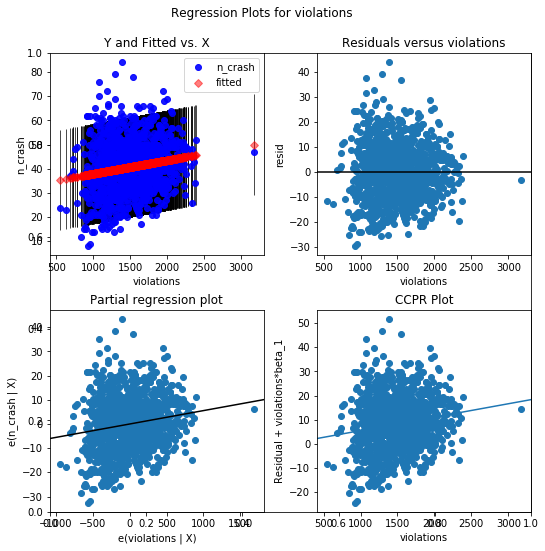

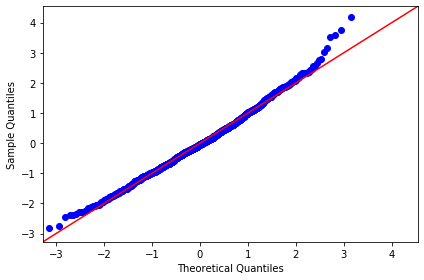




****************************************************************************************************
*                                              N_CRASH                                             *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.597e+32
Date:                Sun, 21 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:04:08   Log-Likelihood:                 36837.
No. Observations:                1217   AIC:                        -7.367e+04
Df Residuals:                    1215   BIC:                        -7.366e

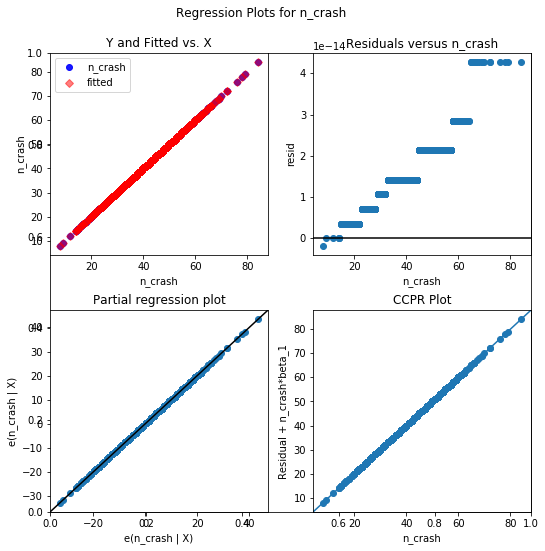

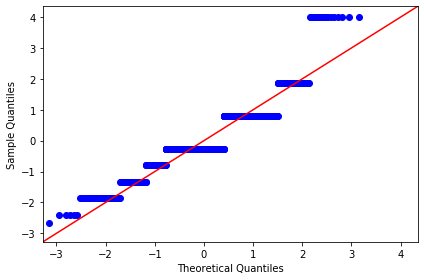




****************************************************************************************************
*                                      MORNING_RUSH_CONGESTION                                     *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     75.71
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.08e-17
Time:                        23:04:10   Log-Likelihood:                -4455.2
No. Observations:                1187   AIC:                             8914.
Df Residuals:                    1185   BIC:                             89

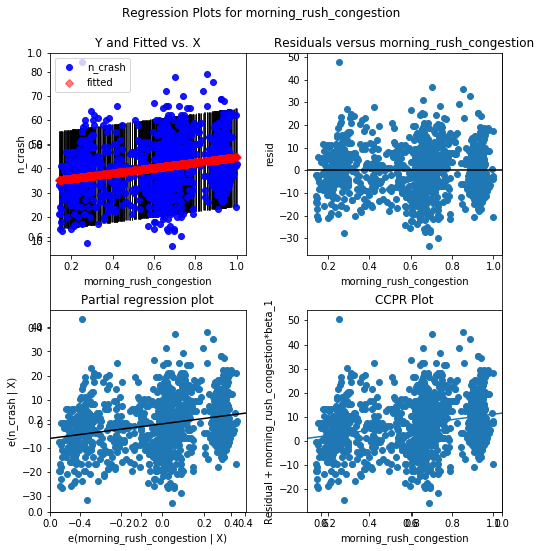

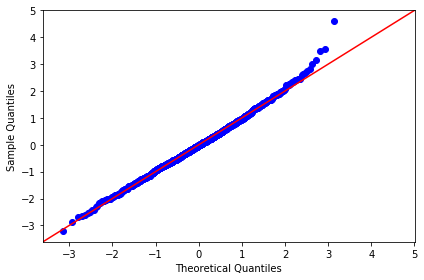




****************************************************************************************************
*                                     AFTERNOON_RUSH_CONGESTION                                    *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     94.81
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           1.31e-21
Time:                        23:04:11   Log-Likelihood:                -4463.8
No. Observations:                1192   AIC:                             8932.
Df Residuals:                    1190   BIC:                             89

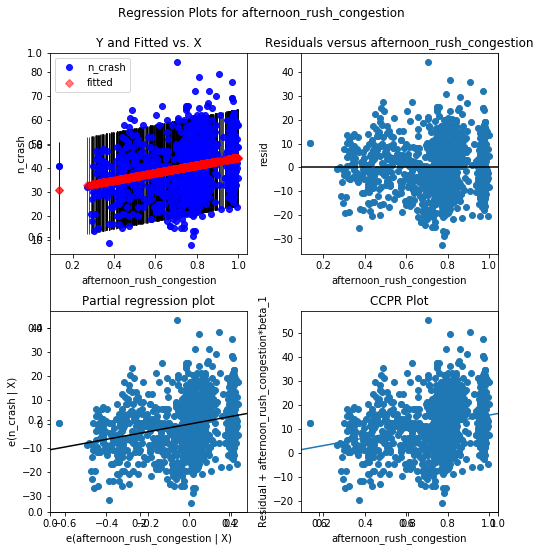

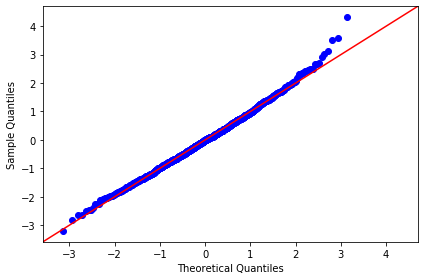




****************************************************************************************************
*                                              PRECIP                                              *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.650
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00333
Time:                        23:04:13   Log-Likelihood:                -4600.5
No. Observations:                1217   AIC:                             9205.
Df Residuals:                    1215   BIC:                             92

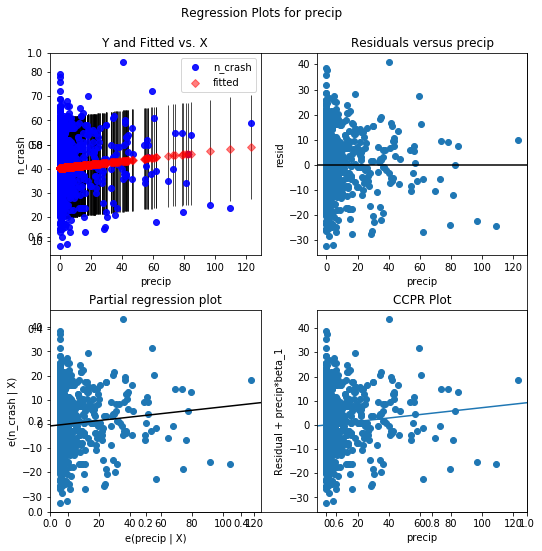

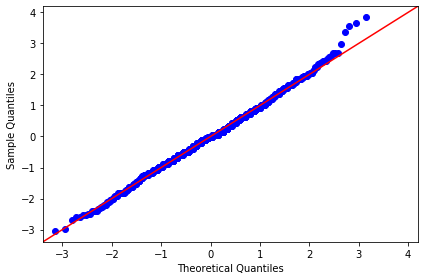




****************************************************************************************************
*                                               TEMP                                               *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.785
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00931
Time:                        23:04:14   Log-Likelihood:                -4601.4
No. Observations:                1217   AIC:                             9207.
Df Residuals:                    1215   BIC:                             92

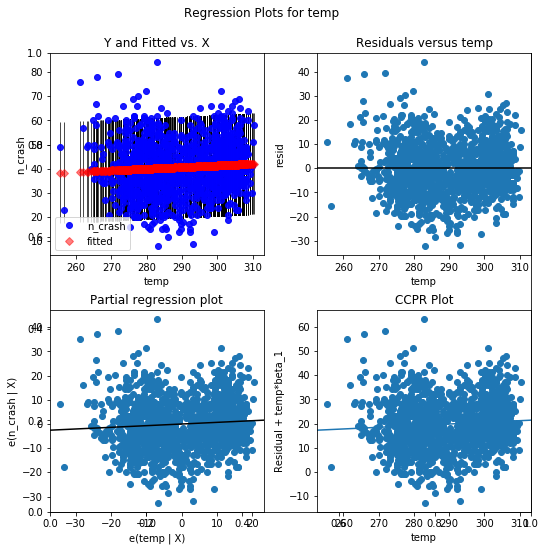

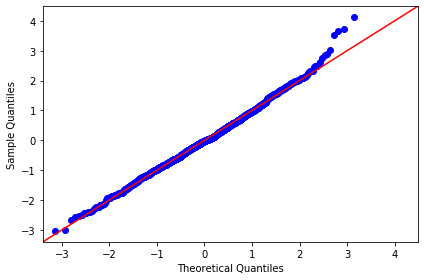




****************************************************************************************************
*                                              N_CAMS                                              *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.82e-06
Time:                        23:04:16   Log-Likelihood:                -4594.3
No. Observations:                1217   AIC:                             9193.
Df Residuals:                    1215   BIC:                             92

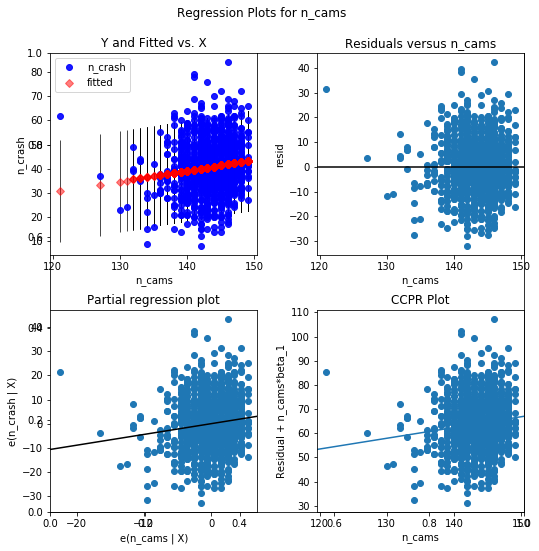

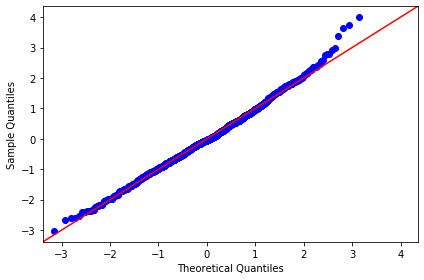




****************************************************************************************************
*                                             CAMS_OFF                                             *
****************************************************************************************************
Red Light Camera - Regression Analysis and Diagnostics Violations
                            OLS Regression Results                            
Dep. Variable:                n_crash   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           4.82e-06
Time:                        23:04:18   Log-Likelihood:                -4594.3
No. Observations:                1217   AIC:                             9193.
Df Residuals:                    1215   BIC:                             92

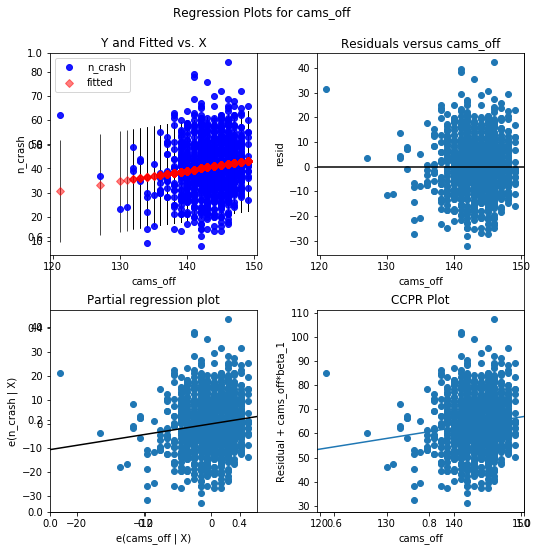

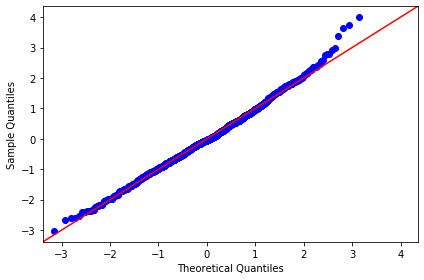

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
5,temp,0.005553,2.085901e+01,0.068422,9.307105e-03,16.812192
4,precip,0.007069,4.033394e+01,0.071167,3.332039e-03,9.288553
6,n_cams,0.017067,-2.325657e+01,0.445547,4.822002e-06,16.419391
7,cams_off,0.017067,-2.325657e+01,0.445547,4.822002e-06,16.419391
0,violations,0.029327,3.242218e+01,0.005549,1.827018e-09,25.856675
2,morning_rush_congestion,0.060056,3.360638e+01,11.082313,1.079453e-17,19.078332
3,afternoon_rush_congestion,0.073792,2.859021e+01,15.842694,1.309843e-21,15.848276
1,n_crash,1.000000,6.217249e-15,1.000000,0.000000e+00,545.354909


In [98]:
# Lets look at some regressions for all of my chosen columns

# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# Eliminated and useful features
target = 'n_crash'
drop_me = ['day', 'min_speed', 'speed', 'quantile_speed', 'avg_congestion',
          'afternoon_rush_speed', 'morning_rush_speed', 'afternoon_rush_quant', 'morning_rush_quant',
          'injuries_total', 'injuries_fatal', 'n_crash', 'rain', 'year', 'snow', 'month']
drop_me.remove(target)
categoricals = ['weekday']

df_cont = crash_df.copy()
df_cont.drop(columns=drop_me+categoricals, inplace=True)



results = []

for idx, column in enumerate(df_cont.columns):
    
    print('\n'*2)
    print('*'*100)
    print('*' + (49-len(column)//2)*' ' + column.upper() + (49-len(column)//2 - len(column)%2)*' ' + '*')
    print('*'*100)

    print ("Red Light Camera - Regression Analysis and Diagnostics Violations")
    
    f = '{}~{}'.format(target, column)  # create my model formula
    model = smf.ols(formula=f, data=df_cont).fit()  # fit the model
    print(model.summary())
    
    fig, axes = plt.subplots(figsize=(8,8))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

result_df = pd.DataFrame(results, columns=['ind_var', 'r_squared', 'intercept', 'slope', 'p-value', 'normality (JB)' ])
result_df.sort_values(by='r_squared')

In [99]:
# scatter plot takes a few min

# pd.plotting.scatter_matrix(df_cont,figsize  = [20, 20]);
# plt.show()

In [100]:
df_cont.corr()  # create a correlation matrix

,violations,n_crash,morning_rush_congestion,afternoon_rush_congestion,precip,temp,n_cams,cams_off
violations,1.000000,0.171250,-0.281585,-0.318495,-0.127594,0.681941,0.543651,0.543651
n_crash,0.171250,1.000000,0.245062,0.271647,0.084079,0.074519,0.130640,0.130640
morning_rush_congestion,-0.281585,0.245062,1.000000,0.931563,0.002774,-0.030142,-0.146495,-0.146495
afternoon_rush_congestion,-0.318495,0.271647,0.931563,1.000000,-0.036268,-0.140838,-0.163856,-0.163856
precip,-0.127594,0.084079,0.002774,-0.036268,1.000000,0.051028,-0.104997,-0.104997
temp,0.681941,0.074519,-0.030142,-0.140838,0.051028,1.000000,0.367890,0.367890
n_cams,0.543651,0.130640,-0.146495,-0.163856,-0.104997,0.367890,1.000000,1.000000
cams_off,0.543651,0.130640,-0.146495,-0.163856,-0.104997,0.367890,1.000000,1.000000


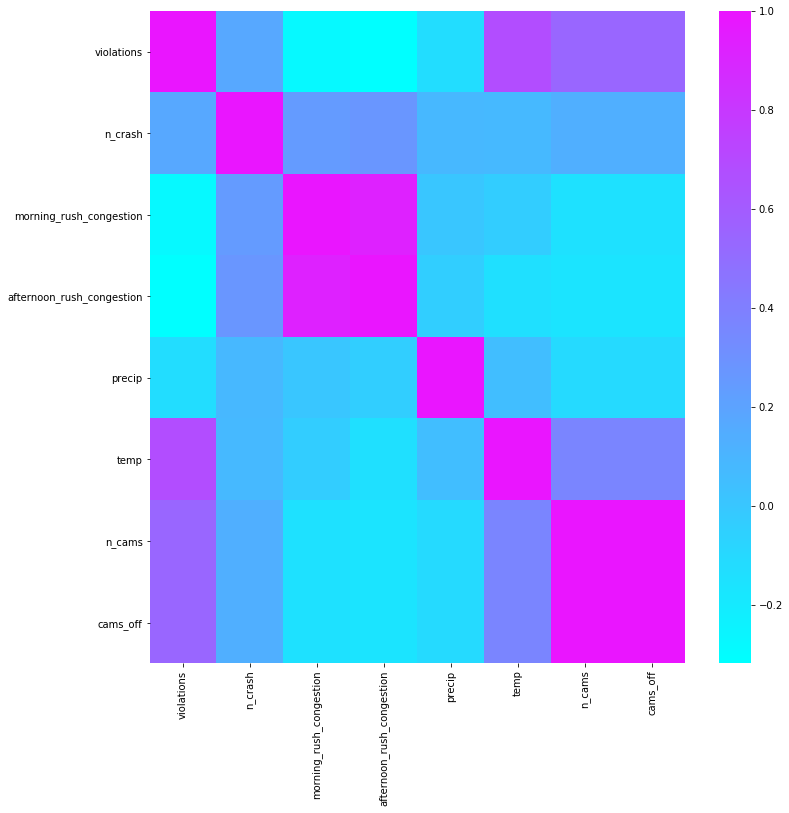

In [101]:
import seaborn as sns

plt.figure(figsize = (12,12))
sns.heatmap(df_cont.corr(), center=0.4, cmap = "cool");

# One Hot Encoding

In [102]:
df_continuous.columns

Index(['violations', 'n_crash', 'morning_rush_congestion',
       'afternoon_rush_congestion', 'precip', 'temp', 'n_cams', 'cams_off'],
      dtype='object')

In [105]:
# get rid of categories that have high correlation and others.
df_continuous = df_cont.copy()
df_ohe = crash_df.copy().drop(columns=list(df_continuous.columns)+[target] + drop_me)

#string_me = ['month', 'year']
#df_ohe[string_me] = df_ohe[string_me].astype(str)

# One hot encoding   
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
df_final = pd.concat([df_continuous, df_ohe], axis=1)

In [106]:
pd.options.display.max_columns = 100
df_final.head()

,violations,n_crash,morning_rush_congestion,afternoon_rush_congestion,precip,temp,n_cams,cams_off,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1704,39,0.878931,0.947914,0.00,294.15,144,144,0,0,0,0,0,0
1,1623,30,0.505119,0.777568,0.00,297.15,143,143,0,1,0,0,0,0
2,1494,29,0.376489,0.573442,6.60,302.15,139,139,0,0,1,0,0,0
3,1258,19,0.358173,0.579923,1.12,303.15,142,142,1,0,0,0,0,0
4,1366,39,0.936206,0.963242,0.00,297.15,144,144,0,0,0,0,1,0


In [107]:
df_final.dropna(inplace=True)

### Test train split

In [108]:
X = df_final.drop(['n_crash'], axis=1)
y = df_final['n_crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [109]:
reg = LinearRegression()
reg.fit(X, y)  # my regression object

pred = reg.predict(X_test)

(0, 60)

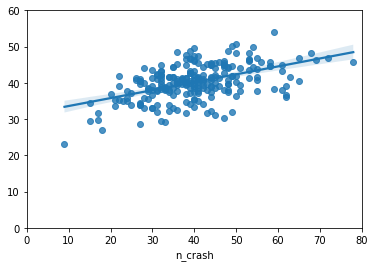

In [110]:
sns.regplot(y_test, pred)
plt.xlim(0,80)
plt.ylim(0,60)

### Plot residuals

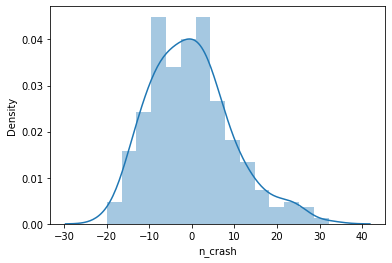

In [111]:
sns.distplot((y_test - pred), bins=15);

In [112]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

print("Linear Regression Results:")
print('=========================')
print('Test set:')
print_evaluate(y_test, test_pred)

print()
print('Train set:')
print_evaluate(y_train, train_pred)

Linear Regression Results:
Test set:
MAE: 7.606335369296179
MSE: 92.59776155846633
RMSE: 9.622773070090883
R2 Square 0.2449441540559666

Train set:
MAE: 7.419830830050337
MSE: 88.45831734758448
RMSE: 9.40522819221227
R2 Square 0.19833991223323355


In [113]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(reg, X_train, y_train)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,7.606335,92.597762,9.622773,0.244944,0.16411


In [114]:
coefficients = dict(zip(X.columns,list(reg.coef_)))
for var in coefficients:
    print('{:28}{}'.format(var, coefficients[var]))



violations                  0.009225175204683408
morning_rush_congestion     1.5145847779770811
afternoon_rush_congestion   20.808772717110447
precip                      0.12549224739629009
temp                        -0.08692660902119458
n_cams                      0.12720190613566168
cams_off                    0.12720190613566112
weekday_Monday              -4.660050174247228
weekday_Saturday            0.18707981818968825
weekday_Sunday              -3.8430025686214653
weekday_Thursday            -3.701477927545373
weekday_Tuesday             -3.297740104231207
weekday_Wednesday           -4.261893571270478


### Result

This model looked at around 50k intersection related crashes at traffic signals.

A linear regression was chosen, so we could better make sense of the results and see the affect of each variable.

Crashes have a lot of noise in the data and are relatively infrequent events at intersections (the average Chicago intersection only has 0.4 accidents per month), so it isn't surprising to see this result. (3000 signaled intersections

Around 20% of the crashes could be explained by the model.  

Weekends (Sat/Sun) average about 4 additional accidents citywide over a typical weekday.
For every 8mm of rain/snow, we can expect an additional crash.

In the worst afternoon rush hour, you would expect 5 additional accidents.
In the best afternoon rush hour, you would expect 9 fewer accidents than average. 
(congestion is scaled from 0 to 1.  The max afternoon rush is 1, and the min is 0.13.  Mean is 0.76)



0.4166666666666667